# **Programming for Applied Deep Learning (GKSG008-01)**
> ### **20181202 김수미**
> ### LeNet_with_Conv2d(2) (Based on 11/18 Lecture)

2. Try CIFAR10: https://pytorch.org/vision/stable/datasets.html#cifar with LeNet.
- Load cifar10 dataset instead of MNIST
- Cifar10 is of 3 channels. You need to modify the declaration of the first conv2d layer so that it may accept a 3 channel input image
- The image is of size 32x32 (not 28x28 any more). You need to modify the value of "in_features" for the first linear layer, which means you need to figure out the number of total features from the last conv2d layer.

**◦ Import Libraries and Define Functions.**

In [ ]:
pip install d2l

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.utils.data as data
import warnings
warnings.filterwarnings('ignore')

from d2l.torch import *
from torch import nn
from d2l import torch as d2l
from torch.utils.data import DataLoader

In [ ]:
def load_data_cifar10(batch_size, resize=None):
    trans = [transforms.ToTensor()]
    if resize:
      trans.insert(0,transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.CIFAR10(root="../data",train=True,transform=trans,download=True)
    mnist_test = torchvision.datasets.CIFAR10(root="../data",train=False,transform=trans,download=True)
    return(data.DataLoader(mnist_train,batch_size,shuffle=True,num_workers=4),
           data.DataLoader(mnist_test,batch_size,shuffle=False,num_workers=4))

In [ ]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
  if isinstance(net, nn.Module):
    net.eval()
    if not device:
      device = next(iter(net.parameters())).device
  metric = d2l.Accumulator(2)

  with torch.no_grad():
    for X, y in data_iter:
      if isinstance(X, list):
        X = [x.to(device) for x in X]
      else:
        X = X.to(device)
      y = y.to(device)
      metric.add(d2l.accuracy(net(X), y), y.numel())
  return metric[0] / metric[1]

In [ ]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
  def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
      nn.init.xavier_uniform_(m.weight)

  net.apply(init_weights)
  print('training on', device)
  net.to(device)
  optimizer = torch.optim.SGD(net.parameters(), lr=lr)
  loss = nn.CrossEntropyLoss()
  animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=['train loss', 'train acc', 'test acc'])
  timer, num_batches = d2l.Timer(), len(train_iter)

  for epoch in range(num_epochs):
    metric = d2l.Accumulator(3)
    net.train()
    for i, (X, y) in enumerate(train_iter):
      timer.start()
      optimizer.zero_grad()
      X, y = X.to(device), y.to(device)
      y_hat = net(X)
      l = loss(y_hat, y)
      l.backward()
      optimizer.step()
      with torch.no_grad():
        metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
      timer.stop()
      train_l = metric[0] / metric[2]
      train_acc = metric[1] / metric[2]
      if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
        animator.add(epoch + (i + 1) / num_batches, (train_l, train_acc, None))
    test_acc = evaluate_accuracy_gpu(net, test_iter)
    animator.add(epoch + 1, (None, None, test_acc))
    
  print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, 'f'test acc {test_acc:.3f}')
  print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec 'f'on {str(device)}')

**◦ Load Dataset**

In [ ]:
batch_size = 128
train_iter, test_iter = load_data_cifar10(batch_size)

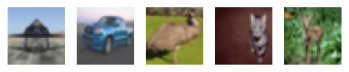

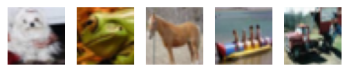

In [ ]:
label = 0; images = []
for data in train_iter:
  x,y = data
  if y[0].item() == label:
    images.append(x[0])
    label += 1
  if label == 10: break

fig1 = plt.figure()
rows,cols = 1,5
for i in range(5):
  ax1 = fig1.add_subplot(rows, cols, i+1)
  ax1.imshow(images[i].permute(1, 2, 0))
  ax1.axis("off")
plt.show()

fig2 = plt.figure()
rows,cols = 1,5
for i in range(5):
  ax1 = fig2.add_subplot(rows, cols, i+1)
  ax1.imshow(images[i+5].permute(1, 2, 0))
  ax1.axis("off")
plt.show()

> **< CIFAR10 Lables >**
- airplane : 0 / automobile : 1 / bird : 2 / cat : 3 / deer : 4
- dog : 5 / frog : 6 / horse : 7 / ship : 8 / truck : 9

**◦ Construct network for CIFAR10 dataset based on LeNet.**

In [ ]:
my_net = nn.Sequential(nn.Conv2d(3, 32, kernel_size=5, padding=2),
                       nn.ReLU(),
                       nn.MaxPool2d(kernel_size=2, stride=2),
                       nn.Conv2d(32, 64, kernel_size=5),
                       nn.ReLU(),
                       nn.MaxPool2d(kernel_size=2, stride=2),
                       nn.Flatten(),
                     
                       # modified the size
                       nn.Linear(2304, 1000), 
                       nn.ReLU(),
                       nn.Linear(1000, 200),
                       nn.Sigmoid(),
                       nn.Linear(200, 10))

**◦ Training Result**

loss 0.000, train acc 1.000, test acc 0.684
6297.1 examples/sec on cuda:0


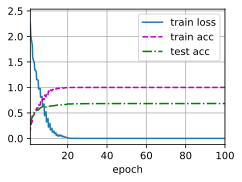

In [ ]:
# Takes about 25 min
# Overfitting Result
lr, num_epochs = 0.6, 100
train_ch6(my_net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

**◦ Display the activations of the first and second layer**

In [ ]:
sample_data = []; flag = 0
for data in train_iter:
  x,y = data
  sample_data.append(x)
  flag += 1
  if flag == 2: break

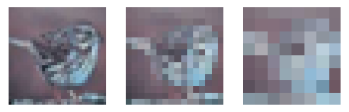

In [ ]:
depth = 1; images=[];

X = sample_data[0]
images.append(X[0])

for layer in my_net:
  if depth == 3 or depth == 6 :
    X = layer(X)
    images.append(X[0])
  depth += 1

fig = plt.figure()
rows,cols = 1,3
for i in range(3):
  ax1 = fig.add_subplot(rows, cols, i+1)
  ax1.imshow(images[i].permute(1, 2, 0))
  ax1.axis("off")
plt.show()

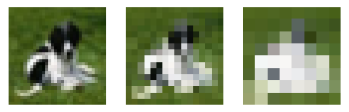

In [ ]:
depth = 1; images=[];

X = sample_data[1]
images.append(X[0])

for layer in my_net:
  if depth == 3 or depth == 6 :
    X = layer(X)
    images.append(X[0])
  depth += 1

fig = plt.figure()
rows,cols = 1,3
for i in range(3):
  ax1 = fig.add_subplot(rows, cols, i+1)
  ax1.imshow(images[i].permute(1, 2, 0))
  ax1.axis("off")
plt.show()